In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import seaborn as sns


## 数据划分

In [ ]:
data = pd.read_csv("insurance_data_preprocessed.csv")
# 只保留风险评分作为目标变量
X = data.drop(['avg_claim_amount', 'total_claims_paid', 'annual_medical_cost', 'claims_count', 'risk_score', 'is_high_risk'], axis=1, errors='ignore')
y = data['is_high_risk']  # 

# 检查原始risk_score的范围
print(f"Original risk_score range: [{y.min():.3f}, {y.max():.3f}]")


# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Original risk_score range: [0.000, 1.000]


Feature correlations with risk_score (sorted):
chronic_count                      0.571784
age                                0.557669
systolic_bp                        0.429379
diastolic_bp                       0.299937
hypertension                       0.297275
visits_last_year                   0.269943
mental_health                      0.246365
annual_premium                     0.241936
monthly_premium                    0.241935
smoker                             0.236441
medication_count                   0.229232
arthritis                          0.228848
diabetes                           0.205566
asthma                             0.163955
hba1c                              0.162228
cardiovascular_disease             0.150167
proc_surgery_count                 0.143792
copd                               0.128098
had_major_procedure                0.098351
cancer_history                     0.097459
proc_imaging_count                 0.092861
proc_lab_count               

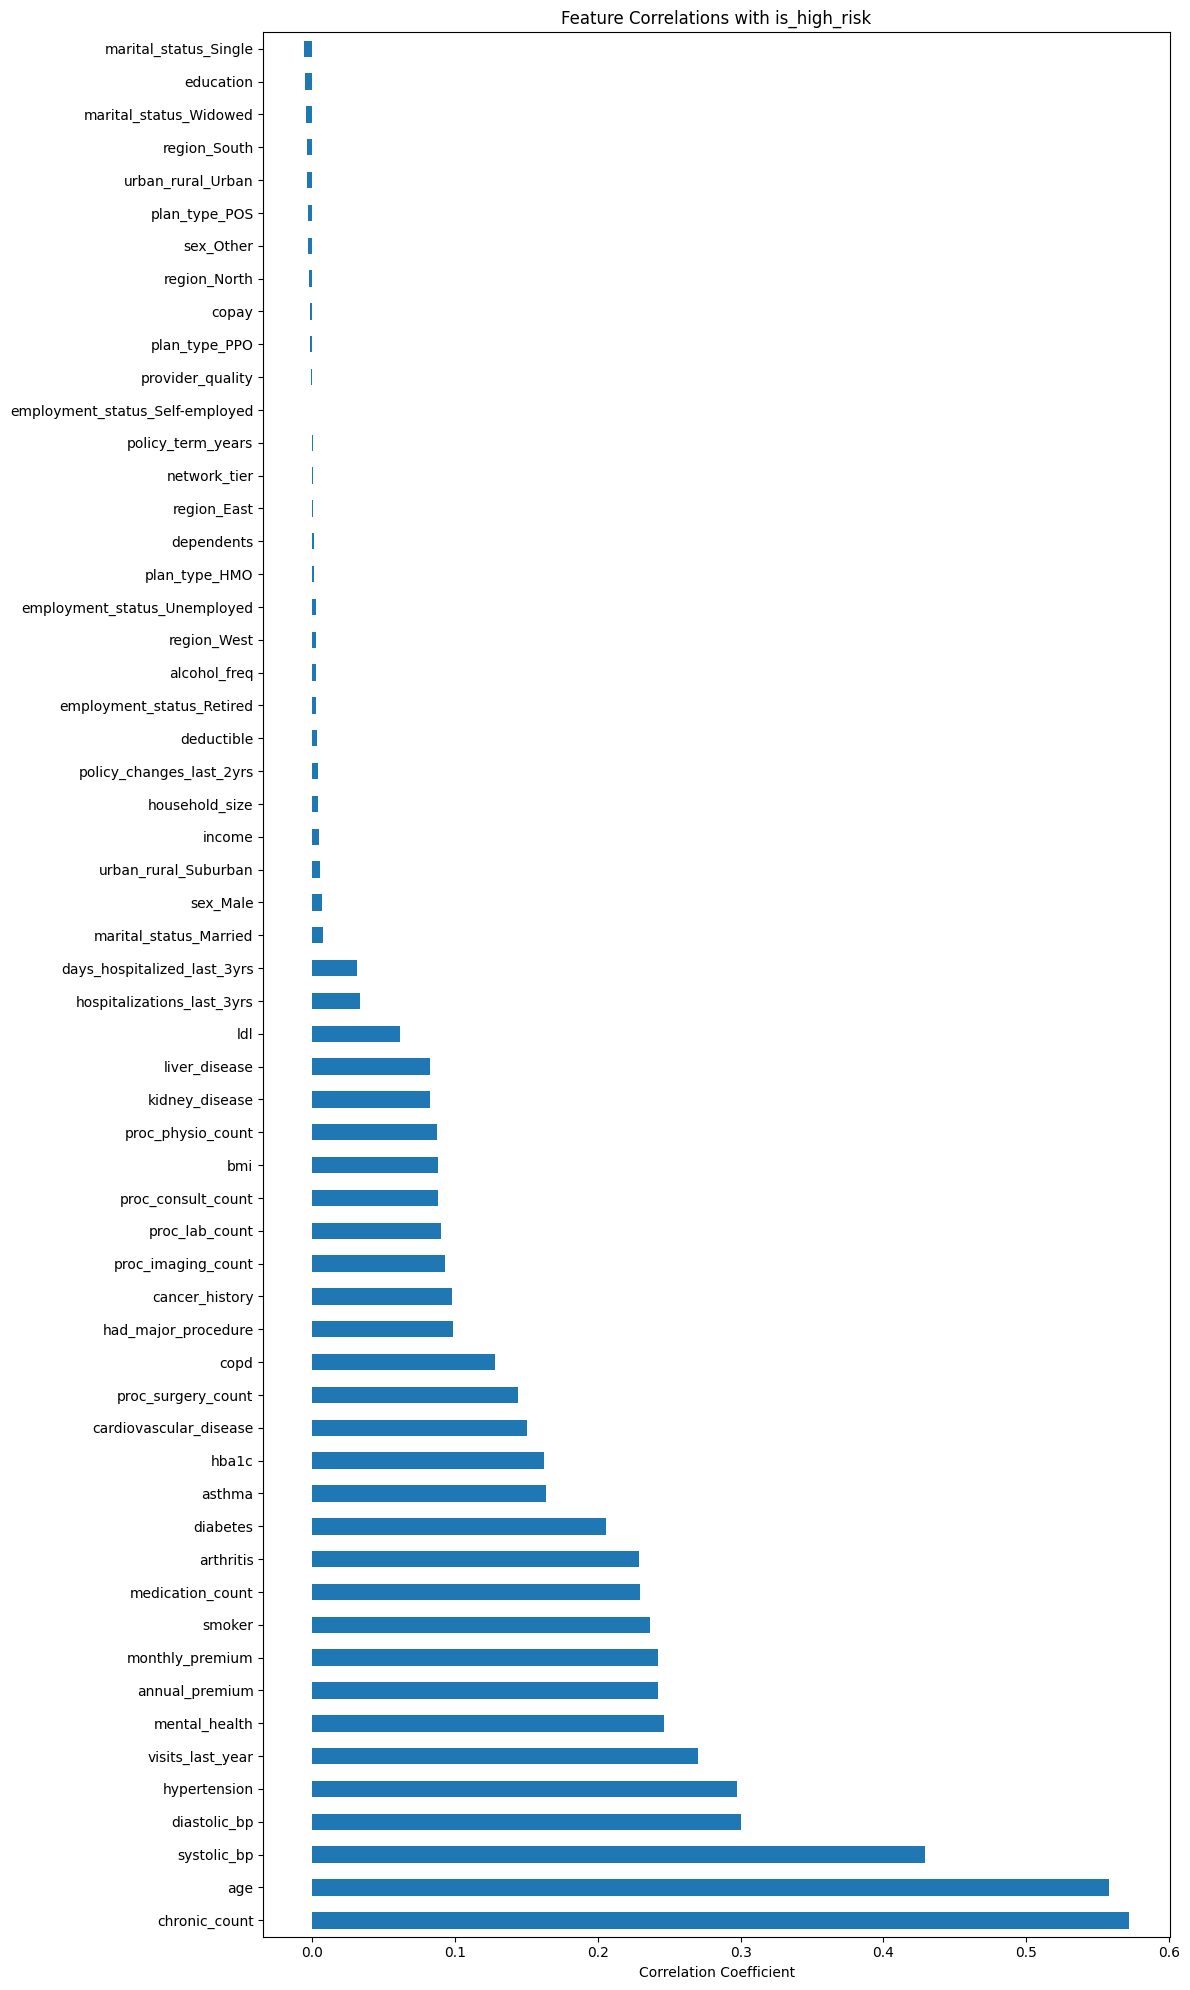

In [4]:
# Calculate correlation between all features and target variable
correlation_with_target = X.corrwith(y).sort_values(ascending=False)  # 计算 is_high_risk 与特征的相关性

print("Feature correlations with risk_score (sorted):")
print(correlation_with_target)

# Plot correlation bar chart
plt.figure(figsize=(12, 20))
correlation_with_target.plot(kind='barh')
plt.title('Feature Correlations with is_high_risk')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


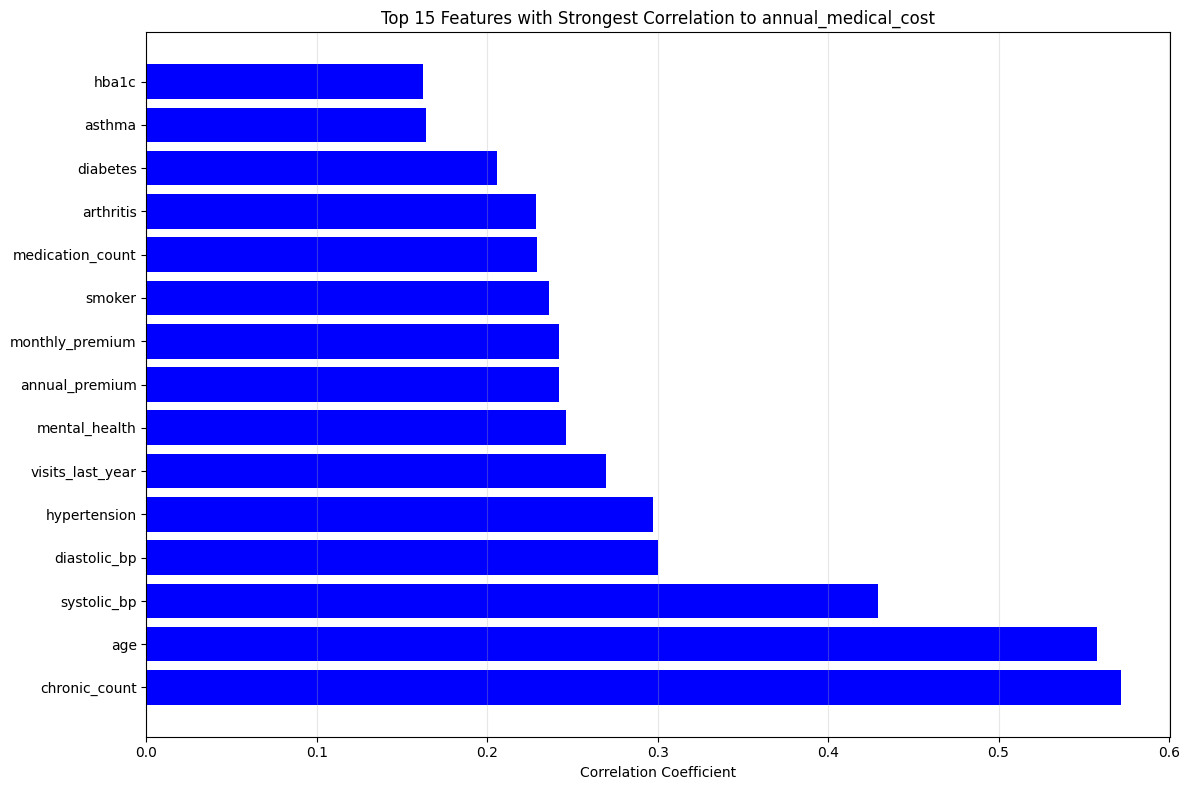

chronic_count       0.571784
age                 0.557669
systolic_bp         0.429379
diastolic_bp        0.299937
hypertension        0.297275
visits_last_year    0.269943
mental_health       0.246365
annual_premium      0.241936
monthly_premium     0.241935
smoker              0.236441
medication_count    0.229232
arthritis           0.228848
diabetes            0.205566
asthma              0.163955
hba1c               0.162228
dtype: float64

In [5]:
top_features_abs = correlation_with_target.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in correlation_with_target[top_features_abs.index]]

plt.barh(range(len(top_features_abs)), correlation_with_target[top_features_abs.index], color=colors)
plt.yticks(range(len(top_features_abs)), top_features_abs.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top 15 Features with Strongest Correlation to annual_medical_cost')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
top_features_abs

## 分类模型

In [6]:

# 准备分类模型
classification_models = {
    "Decision_Tree_Classifier": DecisionTreeClassifier(random_state=42),  # 决策树分类
    "Random Forest Classifier": RandomForestClassifier(random_state=42),  # 随机森林分类
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42),  # 梯度提升分类
    "MLP_Classifier_1": MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', 
                                   solver='adam', batch_size=32, max_iter=1000, random_state=42),  # 前馈神经网络分类
    "MLP_Classifier_2": MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50), activation='relu', 
                                   solver='adam', batch_size=32, max_iter=1000, random_state=42)  # 前馈神经网络分类
}

In [7]:

def classification_train(X_train, X_test, y_train, y_test, models):
    n_models = len(models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (name, model) in enumerate(models.items()):
        time_start = time.time()
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 训练集预测
        y_train_pred = model.predict(X_train)
        
        # 测试集预测
        y_test_pred = model.predict(X_test)
        
        # 计算评估指标 - 训练集
        accuracy_train = accuracy_score(y_train, y_train_pred)
        precision_train = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
        recall_train = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
        f1_train = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        
        # 计算评估指标 - 测试集
        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        
        # 绘制混淆矩阵
        ax = axes[idx]
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{name} Test Accuracy: {accuracy_test:.3f}')
        
        print("Model:", name)
        print("模型在训练集上的评估结果：")
        print(f"Accuracy: {accuracy_train:.4f}")
        print(f"Precision: {precision_train:.4f}")
        print(f"Recall: {recall_train:.4f}")
        print(f"F1-Score: {f1_train:.4f}")
        print()
        
        print("模型在测试集上的评估结果：")
        print(f"Accuracy: {accuracy_test:.4f}")
        print(f"Precision: {precision_test:.4f}")
        print(f"Recall: {recall_test:.4f}")
        print(f"F1-Score: {f1_test:.4f}")
        print('-'*50)
        
        # 显示详细分类报告
        print("详细分类报告：")
        print(classification_report(y_test, y_test_pred, zero_division=0))
        
        time_end = time.time()
        print(f"训练时间: {time_end - time_start:.2f}秒")
        print()

    # 隐藏多余的子图
    for idx in range(len(models), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Confusion Matrix in all model', fontsize=16, y=1.02)
    plt.show()

Model: Decision_Tree_Classifier
模型在训练集上的评估结果：
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

模型在测试集上的评估结果：
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1-Score: 0.9999
--------------------------------------------------
详细分类报告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11744
           1       1.00      1.00      1.00      7335

    accuracy                           1.00     19079
   macro avg       1.00      1.00      1.00     19079
weighted avg       1.00      1.00      1.00     19079

训练时间: 0.53秒

Model: Random Forest Classifier
模型在训练集上的评估结果：
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

模型在测试集上的评估结果：
Accuracy: 0.9942
Precision: 0.9942
Recall: 0.9942
F1-Score: 0.9942
--------------------------------------------------
详细分类报告：
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11744
           1       0.99      0.99      0.99

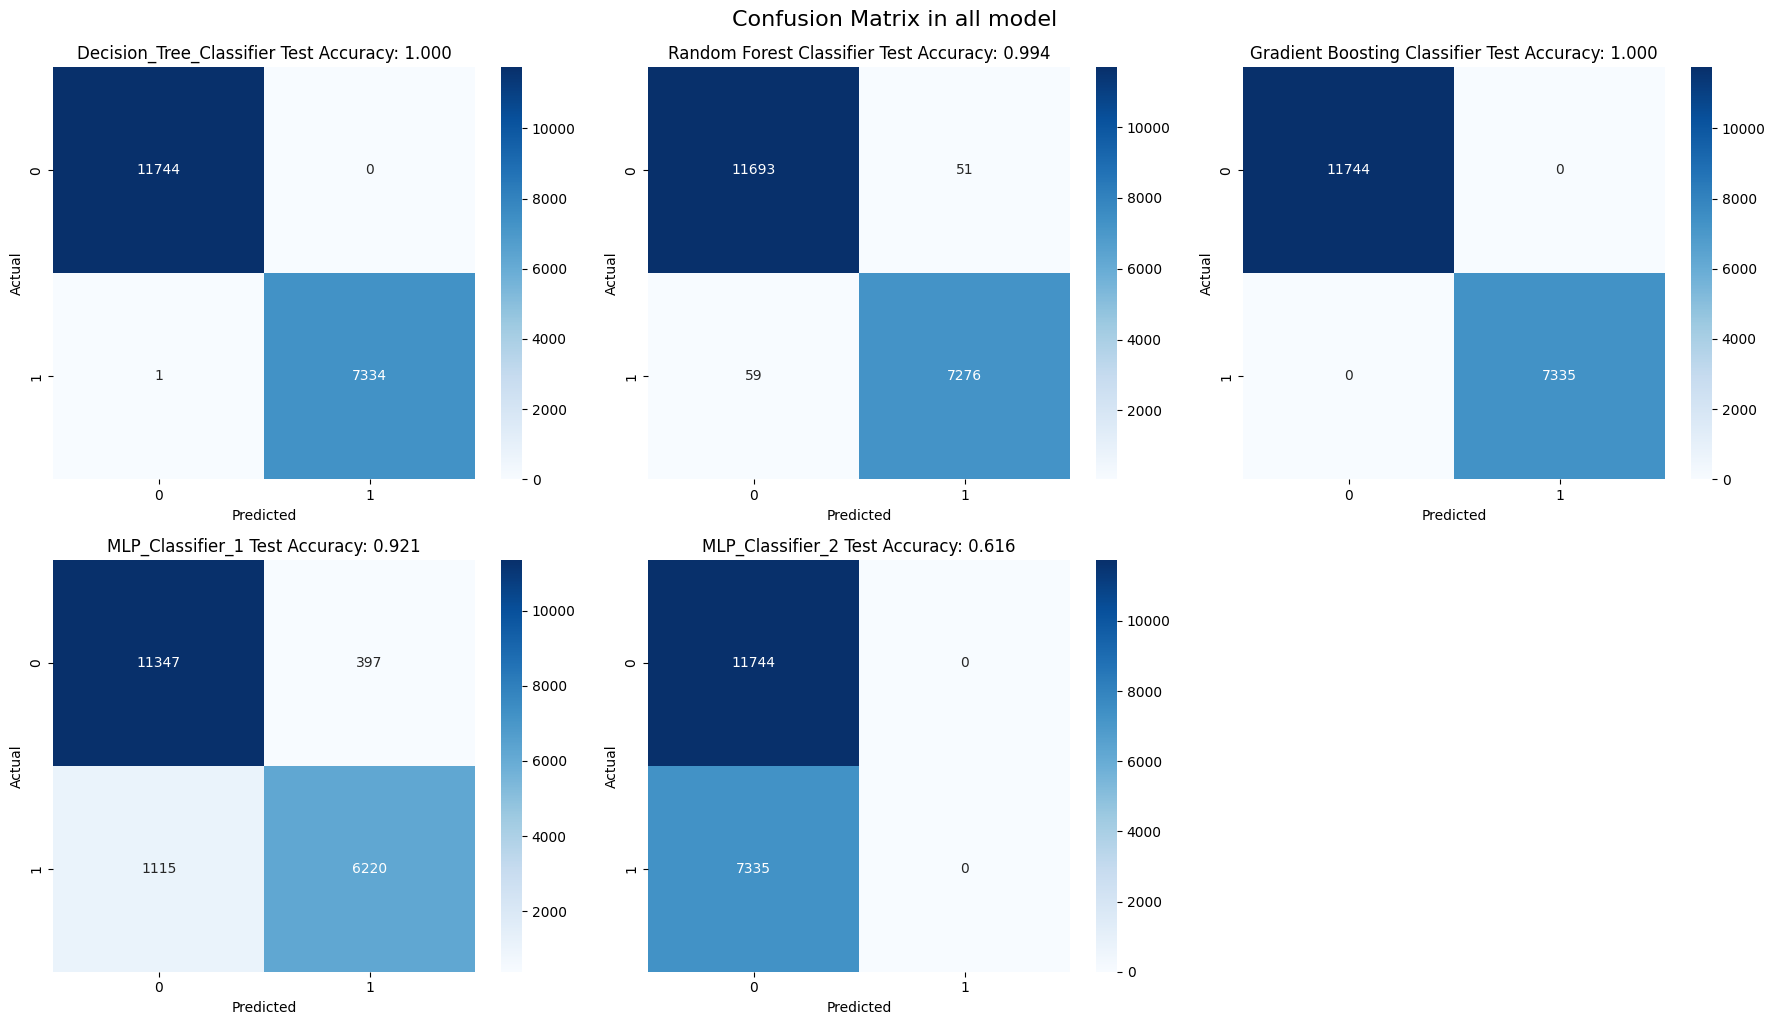

In [8]:

classification_train(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=classification_models)